In [2]:
import torch
from torch import nn
from torchvision import datasets
from torchvision.transforms import v2

torch.__version__

'2.2.1+cu121'

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1.Loading dataset


In [4]:
# Image Transformation function using torchvision.transforms
transform = v2.Compose(
    [
        v2.Resize((224, 224)),
        v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    ]
)

In [7]:
# data is loaded from directory with automatic labeling for different subfolder
train_dir = "data/vehicle_images/train"
test_dir = "data/vehicle_images/test"
train_data = datasets.ImageFolder(train_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)
len(train_data), len(test_data)

(555, 133)

In [8]:
from torch.utils.data import DataLoader

# Looading the data from the dataset objects
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [10]:
# Specifying names for labels
class_names = train_data.classes
class_names

['four wheeler', 'two wheeler']

In [11]:
# Separating features and labels into different tensors from the dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_labels_batch

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1])

## 2.Visualizing random sample from the training dataset


Image size: torch.Size([3, 224, 224])
Label: 1, label size: torch.Size([])


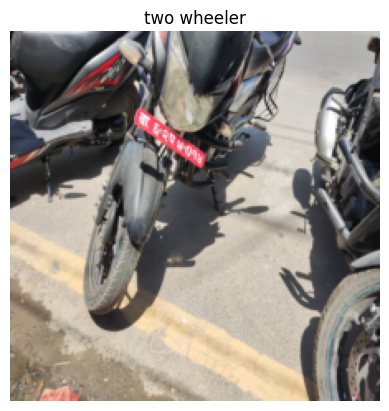

In [14]:
import matplotlib.pyplot as plt

torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(
    img.permute(
        1, 2, 0
    )  # Matplotlib only accepts img matrix in shape HeightxWidthxColor, Pytorch tensor in ColorxHeightxWidth
)
plt.title(class_names[label.item()])
plt.axis("Off")
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Defining CNN for Image Classification


In [15]:
class VehicleClassifier(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,  # how big is the square that's going over the image?
                stride=1,  # default
                padding=1,
            ),  # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, stride=2
            ),  # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units * 56 * 56, out_features=output_shape),
        )

    def forward(self, x: torch.Tensor):
        # UNCOMMENT THE PRINT SHAPES TO FIND OUT CLASSIFIER INPUT FEATURE SHAPE
        # x = self.block_1(x)
        # # print(x.shape)
        # x = self.block_2(x)
        # # print(x.shape)
        # x = self.classifier(x)
        return self.classifier(self.block_2(self.block_1(x)))

        return x

### Creating model with class initialization


In [138]:
torch.manual_seed(42)
# Output shape = 1 for BCE, 2 for CrossEntropy


model = VehicleClassifier(input_shape=3, hidden_units=32, output_shape=2).to(device)

In [139]:
# To check input features of classifier layer
# First, uncomment print(x.shape) lines in forward method
model(img.unsqueeze(0).to(device))

tensor([[0.0200, 0.0084]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [140]:
import torchinfo
from torchinfo import summary

summary(model, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
VehicleClassifier                        [1, 2]                    --
├─Sequential: 1-1                        [1, 32, 112, 112]         --
│    └─Conv2d: 2-1                       [1, 32, 224, 224]         896
│    └─ReLU: 2-2                         [1, 32, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 32, 224, 224]         9,248
│    └─ReLU: 2-4                         [1, 32, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 32, 112, 112]         --
├─Sequential: 1-2                        [1, 32, 56, 56]           --
│    └─Conv2d: 2-6                       [1, 32, 112, 112]         9,248
│    └─ReLU: 2-7                         [1, 32, 112, 112]         --
│    └─Conv2d: 2-8                       [1, 32, 112, 112]         9,248
│    └─ReLU: 2-9                         [1, 32, 112, 112]         --
│    └─MaxPool2d: 2-10                   [1, 32, 56, 56]           --
├─Seq

## 4. Functionizing Train/test loop


In [134]:
def train_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(
    model: torch.nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [135]:
from tqdm.auto import tqdm


# 1. Take in various parameters required for training and test steps
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
    epochs: int = 5,
):

    # 2. Create empty results dictionary
    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
        )
        test_loss, test_acc = test_step(
            model=model, dataloader=test_dataloader, loss_fn=loss_fn
        )

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

## 5.Training our model


In [143]:
# Instantiating model
model0 = VehicleClassifier(input_shape=3, hidden_units=32, output_shape=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [144]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Start the timer
from timeit import default_timer as timer

start_time = timer()

# Train model_0
model_0_results = train(
    model=model0,
    train_dataloader=train_loader,
    test_dataloader=test_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=NUM_EPOCHS,
)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\nishc\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
c:\Users\nishc\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\JpegImagePlugin.py:853: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn(
  8%|▊         | 1/12 [01:58<21:45, 118.70s/it]

Epoch: 1 | train_loss: 0.4010 | train_acc: 0.8293 | test_loss: 0.4066 | test_acc: 0.8550


 17%|█▋        | 2/12 [03:58<19:53, 119.30s/it]

Epoch: 2 | train_loss: 0.2804 | train_acc: 0.8935 | test_loss: 0.3650 | test_acc: 0.8738


 25%|██▌       | 3/12 [05:58<17:55, 119.53s/it]

Epoch: 3 | train_loss: 0.2413 | train_acc: 0.9265 | test_loss: 0.4131 | test_acc: 0.8488


 33%|███▎      | 4/12 [07:56<15:52, 119.09s/it]

Epoch: 4 | train_loss: 0.1934 | train_acc: 0.9421 | test_loss: 0.3412 | test_acc: 0.8475


 42%|████▏     | 5/12 [09:55<13:53, 119.01s/it]

Epoch: 5 | train_loss: 0.1137 | train_acc: 0.9618 | test_loss: 0.2783 | test_acc: 0.9250


 50%|█████     | 6/12 [11:53<11:52, 118.79s/it]

Epoch: 6 | train_loss: 0.0432 | train_acc: 0.9878 | test_loss: 0.2324 | test_acc: 0.9250


 58%|█████▊    | 7/12 [13:52<09:53, 118.66s/it]

Epoch: 7 | train_loss: 0.0166 | train_acc: 0.9983 | test_loss: 0.3037 | test_acc: 0.9062


 67%|██████▋   | 8/12 [15:50<07:54, 118.64s/it]

Epoch: 8 | train_loss: 0.0027 | train_acc: 1.0000 | test_loss: 0.2935 | test_acc: 0.8988


 75%|███████▌  | 9/12 [17:49<05:55, 118.55s/it]

Epoch: 9 | train_loss: 0.0012 | train_acc: 1.0000 | test_loss: 0.3119 | test_acc: 0.8988


 83%|████████▎ | 10/12 [19:47<03:56, 118.49s/it]

Epoch: 10 | train_loss: 0.0006 | train_acc: 1.0000 | test_loss: 0.3403 | test_acc: 0.8988


 92%|█████████▏| 11/12 [21:46<01:58, 118.62s/it]

Epoch: 11 | train_loss: 0.0004 | train_acc: 1.0000 | test_loss: 0.3489 | test_acc: 0.8988


100%|██████████| 12/12 [23:45<00:00, 118.78s/it]

Epoch: 12 | train_loss: 0.0003 | train_acc: 1.0000 | test_loss: 0.3609 | test_acc: 0.8988
Total training time: 1425.341 seconds


## 6.Plotting Loss Curves


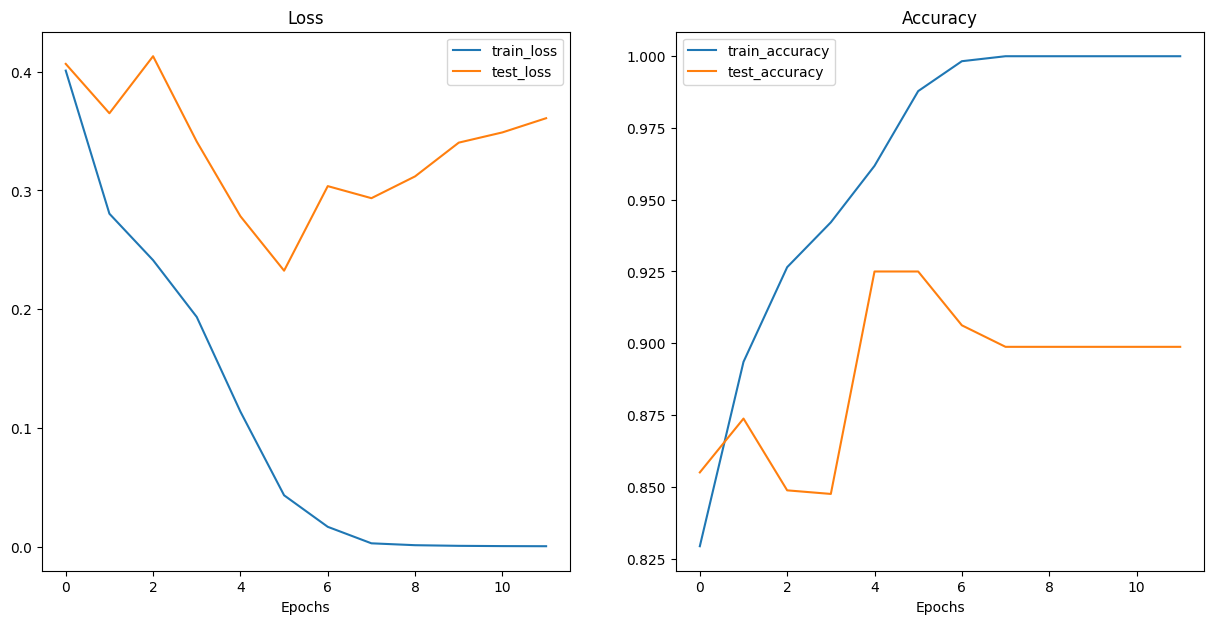

In [145]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_0_results)

## 7. Evaluating on unseen images


In [146]:
new_dir = "data/unseen"
unseen_dataset = datasets.ImageFolder(new_dir, transform=transform)
len(unseen_dataset)

20

In [147]:
unseen_loader = DataLoader(
    unseen_dataset,
    shuffle=False,
)

### Creating a Prediction function for Test Samples


In [148]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = sample.to(device)  # Add an extra dimension for batch

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(
                pred_logit, dim=1
            )  # Perform softmax on the channel dimension

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.cat(pred_probs, dim=0)

### Getting Test samples/labels separately from Unseen_loader


In [149]:
test_samples = []
test_labels = []
for sample, label in unseen_loader:
    test_samples.append(sample)
    test_labels.append(label.item())
sample.shape

torch.Size([1, 3, 224, 224])

### Making predictions for test samples


In [150]:
pred_probs = make_predictions(model=model, data=test_samples)
# View first two prediction probabilities list
# Converting prediction probabilities into labels
pred_labels = pred_probs.argmax(dim=1)
pred_labels

tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0])

### Visualizing our predictions on Unseen data


In [151]:
# Calculating accuracy of prediction on new images
correct = 0
total = 0
with torch.no_grad():
    for images, labels in unseen_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy on new images: {accuracy:.2f}%")

Accuracy on new images: 60.00%


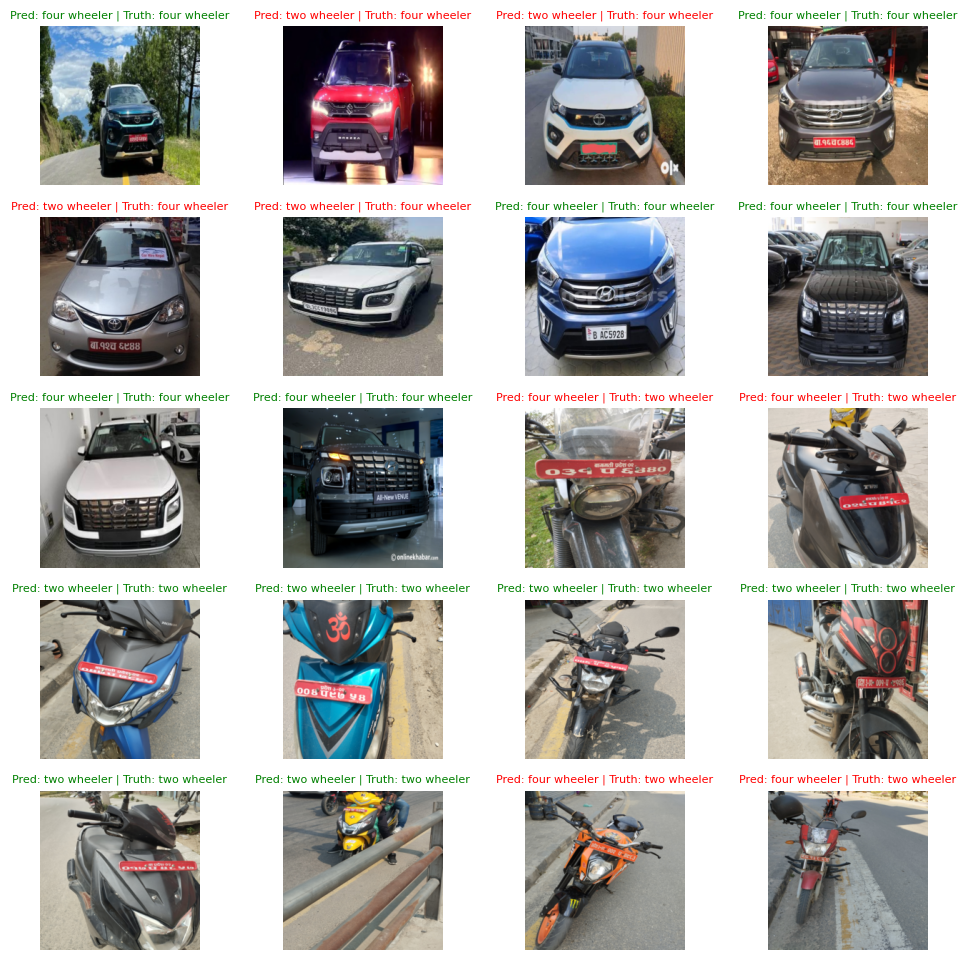

In [152]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 5
ncols = 4
for i, sample in enumerate(test_samples):
    # Create a subplot
    plt.subplot(nrows, ncols, i + 1)

    # Plot the target image
    sample = sample.squeeze()
    plt.imshow(sample.permute(1, 2, 0))

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_labels[i].item()]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[test_labels[i]]

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=8, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=8, c="r")  # red text if wrong
    plt.axis(False)